In [2]:
!conda install -c conda-forge torchmetrics -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - torchmetrics


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    faiss-proc-1.0.0           |             cuda          18 KB  conda-forge
    ninja-1.11.0               |       h924138e_0         2.8 MB  conda-forge
    pytorch-1.12.1             |cpu_py37h14e09b7_0        65.0 MB  conda-forge
    sleef-3.5.1                |       h9b69904_2         1.5 MB  conda-forge
    torchmetrics-0.11.0        |     pyhd8ed1ab_0         206 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        69.5 MB

The following NEW 

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import torch.nn as nn
from torch.autograd import Variable

from torchmetrics.functional import dice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
transform = transforms.Compose(
    [transforms.Resize((256, 256)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

target_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: (x-1).squeeze().type(torch.LongTensor))
])

In [16]:
trainset = OxfordIIITPet(root='./data', split='trainval', target_types='segmentation', download=True, transform=transform, target_transform=target_transform)
testset = OxfordIIITPet(root='./data', split='test', target_types='segmentation', download=True, transform=transform, target_transform=target_transform)

In [17]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

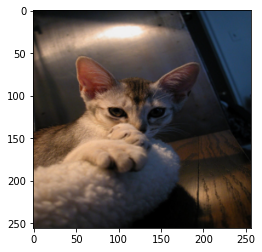

In [9]:
imshow(trainloader.dataset[10][0])

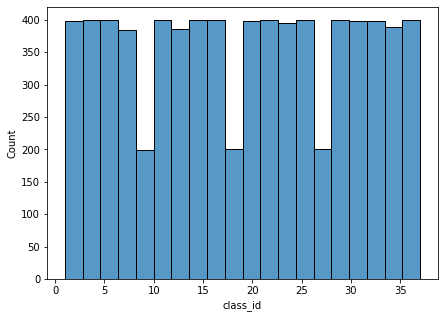

In [10]:
df = pd.read_csv("/kaggle/working/data/oxford-iiit-pet/annotations/list.txt", delimiter=" ", skiprows=6, header=None, names=["stem", "class_id", "species", "breed"])

plt.figure(figsize=(7,5))
sns.histplot(df.class_id)
plt.show()

## LinkNet

In [18]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn3 = nn.BatchNorm2d(out_planes)
        self.conv4 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn4 = nn.BatchNorm2d(out_planes)
        self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)
    def forward(self, x):
        
        #x = self.block1(x)
        
        x_0 = self.downsample(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x += x_0
        x = self.relu(x)
        
        
        #x = self.block2(x)
        
        x_0 = x
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        
        x += x_0
        x = self.relu(x)

        return x

In [19]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [20]:
class LinkNet(nn.Module):

    def __init__(self, n_classes=37):

        super(LinkNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)

        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        #self.lsm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initial block
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)

        #y = self.lsm(y)

        return y
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = LinkNet().to(device)

cuda:0


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
epochs = 10
running_loss_history = []
running_corrects_history = []
running_dice_history = []
val_running_loss_history = []
val_running_corrects_history = []
val_running_dice_history = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    val_dice_score = 0
    train_running_loss = 0.0
    train_running_corrects = 0.0
    train_dice_score = 0.0

    for inputs, labels in tqdm(trainloader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item()
            val_running_corrects += torch.mean((preds == labels.data).type(torch.float64))
            val_dice_score += dice(preds, labels, average='macro', num_classes=3)
            
    with torch.no_grad():
        for inputs, labels in tqdm(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            train_running_loss += loss.item()
            train_running_corrects += torch.mean((preds == labels.data).type(torch.float64))
            train_dice_score += dice(preds, labels, average='macro', num_classes=3)
            
    epoch_loss = train_running_loss/(len(trainloader)*batch_size)
    epoch_acc = train_running_corrects.float()/(len(trainloader))
    epoch_dice = train_dice_score / len(trainloader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc.cpu().numpy())
    running_dice_history.append(epoch_dice.cpu().numpy())
    
    
    val_epoch_loss = val_running_loss/(len(testloader)*batch_size)
    val_epoch_acc = val_running_corrects.float()/(len(testloader))
    val_epoch_dice = val_dice_score / len(testloader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.cpu().numpy())
    val_running_dice_history.append(val_epoch_dice.cpu().numpy())
    
    print('epoch : ', (epoch+1))
    print('training loss: {:.4f}, accuracy: {:.4f}, dice score: {:.4f}'.format(epoch_loss, epoch_acc.item(), epoch_dice))
    print('validation loss: {:.4f}, validation accuracy: {:.4f}, dice score {:.4f}'.format(val_epoch_loss, val_epoch_acc.item(), val_epoch_dice))

print('\n\nFinished Training')

100%|██████████| 29/29 [00:43<00:00,  1.48s/it]


epoch :  1
training loss: 0.0209, accuracy: 0.5674, dice score: 0.4928
validation loss: 0.0209, validation accuracy: 0.5680, dice score 0.4972


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


epoch :  2
training loss: 0.0142, accuracy: 0.6781, dice score: 0.5421
validation loss: 0.0142, validation accuracy: 0.6793, dice score 0.5466


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


epoch :  3
training loss: 0.0094, accuracy: 0.7297, dice score: 0.5121
validation loss: 0.0094, validation accuracy: 0.7267, dice score 0.5125


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


epoch :  4
training loss: 0.0068, accuracy: 0.7737, dice score: 0.5362
validation loss: 0.0069, validation accuracy: 0.7683, dice score 0.5349


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


epoch :  5
training loss: 0.0054, accuracy: 0.7953, dice score: 0.5661
validation loss: 0.0055, validation accuracy: 0.7868, dice score 0.5627


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


epoch :  6
training loss: 0.0045, accuracy: 0.8251, dice score: 0.6900
validation loss: 0.0046, validation accuracy: 0.8181, dice score 0.6877


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


epoch :  7
training loss: 0.0040, accuracy: 0.8373, dice score: 0.7331
validation loss: 0.0042, validation accuracy: 0.8278, dice score 0.7283


100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


epoch :  8
training loss: 0.0034, accuracy: 0.8607, dice score: 0.7688
validation loss: 0.0036, validation accuracy: 0.8512, dice score 0.7644


100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


epoch :  9
training loss: 0.0031, accuracy: 0.8679, dice score: 0.7842
validation loss: 0.0034, validation accuracy: 0.8549, dice score 0.7758


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]

epoch :  10
training loss: 0.0029, accuracy: 0.8768, dice score: 0.7890
validation loss: 0.0032, validation accuracy: 0.8614, dice score 0.7783


Finished Training


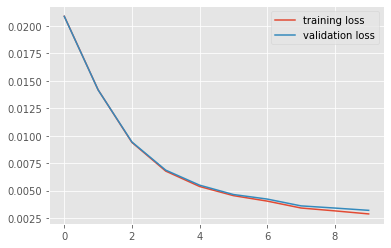

In [16]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()
plt.savefig('loss.pdf')

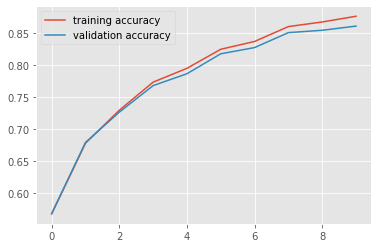

In [17]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()
plt.savefig('acc.pdf')

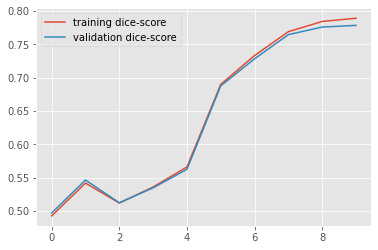

In [18]:
plt.style.use('ggplot')
plt.plot(running_dice_history, label = 'training dice-score')
plt.plot(val_running_dice_history, label = 'validation dice-score')
plt.legend()
plt.savefig('dice.pdf')

In [19]:
# SAVE THE MODEL
PATH = './linknet.pth'
torch.save(net.state_dict(), PATH)

In [22]:
# LOAD THE MODEL
PATH = './linknet.pth'
net = LinkNet().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [14]:
outputs = net(images).cpu()
_, preds = torch.max(outputs, 1)

In [15]:
def show_3(index):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    imshow(images[index])

    plt.subplot(1,3,2)
    imshow(labels[index].unsqueeze(0))

    plt.subplot(1,3,3)
    imshow(preds[index].unsqueeze(0))

    plt.show()

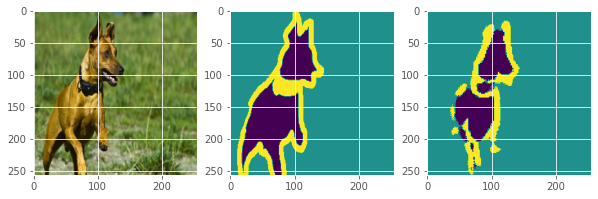

In [24]:
show_3(0)

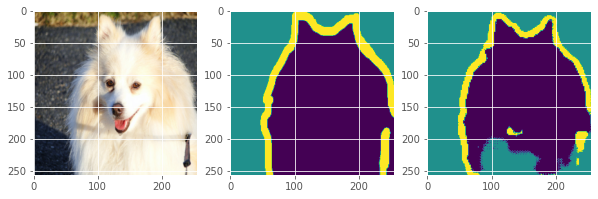

In [25]:
show_3(1)

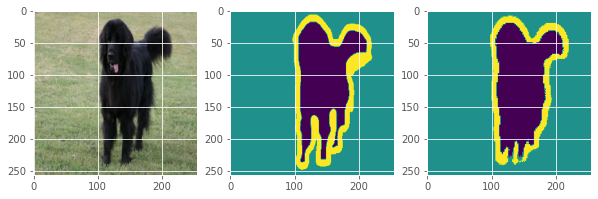

In [26]:
show_3(8)

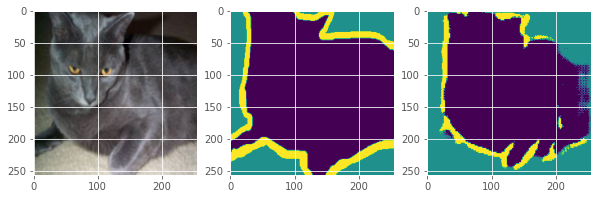

In [27]:
show_3(18)